# Tutorial 2: Mechanism discovery through dimensionality reduction and clustering

## Learning objectives
In this tutorial, you will learn to:
- Work with ensemble models to understand variability in neural network predictions
- Apply UMAP for nonlinear dimensionality reduction of neural responses
- Use Gaussian mixture models to cluster neural network behaviors
- Discover different computational strategies across model instances
- Relate clustering results to simple stimulus responses

## Introduction

Neural networks trained to perform the same task can develop different internal strategies. By analyzing ensembles of models, we can discover these different computational mechanisms. This tutorial shows how to:

1. **Load ensemble models** trained on the same task
2. **Compute responses** to naturalistic stimuli across the ensemble
3. **Apply dimensionality reduction** to find structure in response patterns
4. **Cluster models** based on their response signatures
5. **Validate clusters** using simple, interpretable stimuli


In [1]:
# For Google Colab, uncomment and run this cell to install FlyVis
# !pip install git+https://github.com/TuragaLab/flysim_tutorials.git

In [2]:
# Run this to download the pretrained model ensemble
# !flyvis download-pretrained

## Setup and imports

In [3]:
# For Google Colab, uncomment and run this cell to install FlyVis
# !pip install flyvis

import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.colors as mcolors

# FlyVis imports
import flyvis
from flyvis import EnsembleView
from flyvis.datasets.sintel import AugmentedSintel
from flyvis.analysis.clustering import EnsembleEmbedding, get_cluster_to_indices
from flyvis.utils.activity_utils import CentralActivity
from flyvis.analysis.moving_bar_responses import plot_angular_tuning
from flyvis.analysis.visualization import plt_utils
from flyvis.utils.color_utils import ON_FR, OFF_FR

# Set up plotting
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12


## Part 1: Loading ensemble models and data

Let's start by loading an ensemble of neural networks trained on the same task:


In [4]:
# Load ensemble of networks trained on optic flow task
ensemble = EnsembleView("flow/0000", best_checkpoint_fn_kwargs={ "validation_subdir": "validation","loss_file_name": "loss" })

print(f"Loaded ensemble with {len(ensemble)} networks")
print(f"Each network has {len(ensemble[0].connectome.nodes.type)} nodes")
print(f"Each network has {len(np.unique(ensemble[0].connectome.nodes.type))} node types")


# Show available cell types
cell_types = ensemble[0].connectome.unique_cell_types
print(f"\nAvailable cell types ({len(cell_types)}):")
for i, cell_type in enumerate(cell_types[:10]):  # Show first 10
    print(f"  {cell_type}")
if len(cell_types) > 10:
    print(f"  ... and {len(cell_types) - 10} more")


Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2025-06-19 12:14:28] ensemble:166 Loaded 50 networks.


Loaded ensemble with 50 networks
Each network has 45669 nodes
Each network has 65 node types

Available cell types (65):
  b'R1'
  b'R2'
  b'R3'
  b'R4'
  b'R5'
  b'R6'
  b'R7'
  b'R8'
  b'L1'
  b'L2'
  ... and 55 more


In [5]:
# Load naturalistic stimuli dataset
dt = 1 / 100  # temporal resolution
dataset = AugmentedSintel(
    tasks=["lum"],
    interpolate=False,
    boxfilter={'extent': 15, 'kernel_size': 13},
    temporal_split=True,
    dt=dt,
)

print(f"Dataset contains {len(dataset)} stimulus sequences")
print(f"Each sequence has shape: {dataset[0]['lum'].shape}")


[2025-06-19 12:14:28] sintel_utils:331 Found Sintel at /home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/SintelDataSet


Dataset contains 2268 stimulus sequences
Each sequence has shape: torch.Size([80, 1, 721])


## Part 2: Computing ensemble responses

Now let's compute how all networks in our ensemble respond to the naturalistic stimuli:


In [6]:
np.random.seed(42)
indices = np.random.choice(np.arange(len(dataset)), 
                           size=len(dataset)//20, 
                           replace=False)

# Compute responses across the ensemble
# Note: This may take some time for large ensembles/datasets
print(f"Computing ensemble responses to {len(indices)} naturalistic stimuli...")
print("This may take 10 minutes...")

stims_and_resps = ensemble.naturalistic_stimuli_responses(indices=indices)
responses = stims_and_resps["responses"]

print(f"Response tensor shape: {responses.shape}")
print("Dimensions: (networks, stimuli, time, cell_types, spatial_locations)")


Computing ensemble responses to 113 naturalistic stimuli...
This may take 10 minutes...


/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/526c4ac87066da0fc285ad6032abc85b/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/e8f18c555b8531c0015c97dacbfeea1b/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/3f108a00625cee4381d24b68c935e0d4/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/90028a3356adc4f554a0fc2059b622d4/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/004/__cach

[2025-06-19 12:14:35] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.


/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/008/__cache__/flyvis/analysis/stimulus_responses/compute_responses/7c55f113fc42f624939e6753c693cfd4/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/009/__cache__/flyvis/analysis/stimulus_responses/compute_responses/27ef4f8ffa23fc981209ce4873fe9ffa/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/010/__cache__/flyvis/analysis/stimulus_responses/compute_responses/baa86232df7b55bba60a94a5a9e9a771/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/011/__cache__/flyvis/analysis/stimulus_responses/compute_responses/8e29c2e72997634d1b833611ce4b6d04/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/012/__cach

## Part 3: Dimensionality reduction with UMAP

To understand the structure in response variability, we'll use UMAP (Uniform Manifold Approximation and Projection) for dimensionality reduction:


In [7]:
# Set up parameters for UMAP embedding
embedding_kwargs = {
    "min_dist": 0.105,
    "spread": 9.0,
    "n_neighbors": 5,
    "random_state": 42,
    "n_epochs": 1500,
}

# Prepare data for embedding
central_responses = CentralActivity(responses.values, connectome=ensemble.connectome)
embedding = EnsembleEmbedding(central_responses)

# Compute UMAP embedding for T4c responses
target_cell_type = "T4c"
print(f"Computing UMAP embedding for {target_cell_type} responses...")
t4c_embedding = embedding(target_cell_type, embedding_kwargs=embedding_kwargs)
print("UMAP embedding complete!")


Computing UMAP embedding for T4c responses...


[2025-06-19 12:14:42] clustering:482 reshaped X from (50, 113, 80) to (50, 9040)
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/umap/umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding complete!


## Part 4: Clustering with Gaussian mixture models

Now let's use clustering to identify distinct computational strategies:


In [8]:
# Set up parameters for Gaussian mixture clustering
gm_kwargs = {
    "range_n_clusters": [1, 2, 3, 4, 5],
    "n_init": 100,
    "max_iter": 1000,
    "random_state": 42,
    "tol": 0.001,
}

# Perform clustering
print("Performing Gaussian mixture clustering...")
gm_clustering = t4c_embedding.cluster.gaussian_mixture(**gm_kwargs)

print(f"Optimal number of clusters: {gm_clustering.gm.n_components}")
print(f"Cluster assignments: {gm_clustering.labels}")


Performing Gaussian mixture clustering...


Optimal number of clusters: 3
Cluster assignments: [0 0 0 0 1 1 0 0 2 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 2 1 0 2 0 0 0 2 1 2 0 0
 0 1 2 1 2 0 1 0 2 2 0 0 2]


/tmp/ipykernel_1710005/383846387.py:10: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


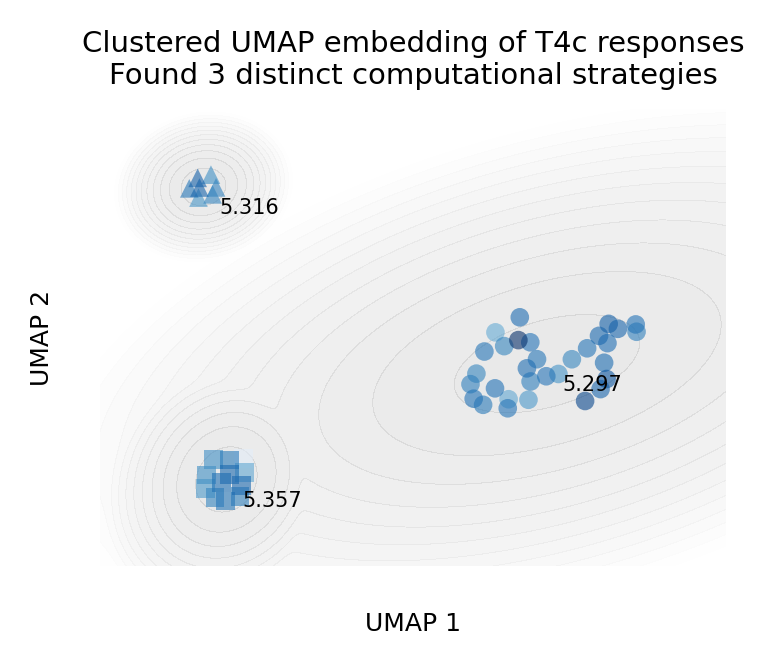


Cluster 1 (31 networks):
  • Task performance: 5.2974 ± 0.0564

Cluster 2 (7 networks):
  • Task performance: 5.3158 ± 0.0432

Cluster 3 (12 networks):
  • Task performance: 5.3572 ± 0.1059



In [9]:
# Plot the clustering results
task_error = ensemble.task_error()  # Get task performance for coloring

embeddingplot = gm_clustering.plot(task_error=task_error.values, colors=task_error.colors)

plt.title(f"Clustered UMAP embedding of {target_cell_type} responses\n" + 
          f"Found {gm_clustering.gm.n_components} distinct computational strategies", fontsize=7)
plt.xlabel("UMAP 1", fontsize=6)
plt.ylabel("UMAP 2", fontsize=6)
plt.tight_layout()
plt.show()

# Show cluster statistics
unique_labels, counts = np.unique(gm_clustering.labels, return_counts=True)

# Get cluster indices for further analysis
cluster_to_indices = get_cluster_to_indices(
    embeddingplot.cluster.embedding.mask,
    embeddingplot.cluster.labels,
    ensemble.task_error(),
)

print("=" * 50)

for cluster_id, indices in cluster_to_indices.items():
    print(f"\nCluster {cluster_id + 1} ({len(indices)} networks):")
    print(f"  • Task performance: {task_error.values[indices].mean():.4f} ± {task_error.values[indices].std():.4f}")

print("\n" + "=" * 50)



## Part 5: Validating clusters with simple stimuli

Now that we've identified computational clusters, let's validate them by testing how they respond to simple, interpretable stimuli. This will help us understand what computational strategies each cluster represents.


In [10]:
print("Networks per cluster:")
for cluster_id, indices in cluster_to_indices.items():
    print(f"  Cluster {cluster_id + 1}: networks {indices}")


Networks per cluster:
  Cluster 1: networks [ 0  1  2  3  6  7  9 11 12 13 14 16 17 18 19 20 21 22 23 24 27 29 30 31
 35 36 37 42 44 47 48]
  Cluster 2: networks [ 4  5 26 33 38 40 43]
  Cluster 3: networks [ 8 10 15 25 28 32 34 39 41 45 46 49]


### 5.1 Response differences in naturalistic stimuli

First, let's visualize how different clusters respond to the same naturalistic stimulus:


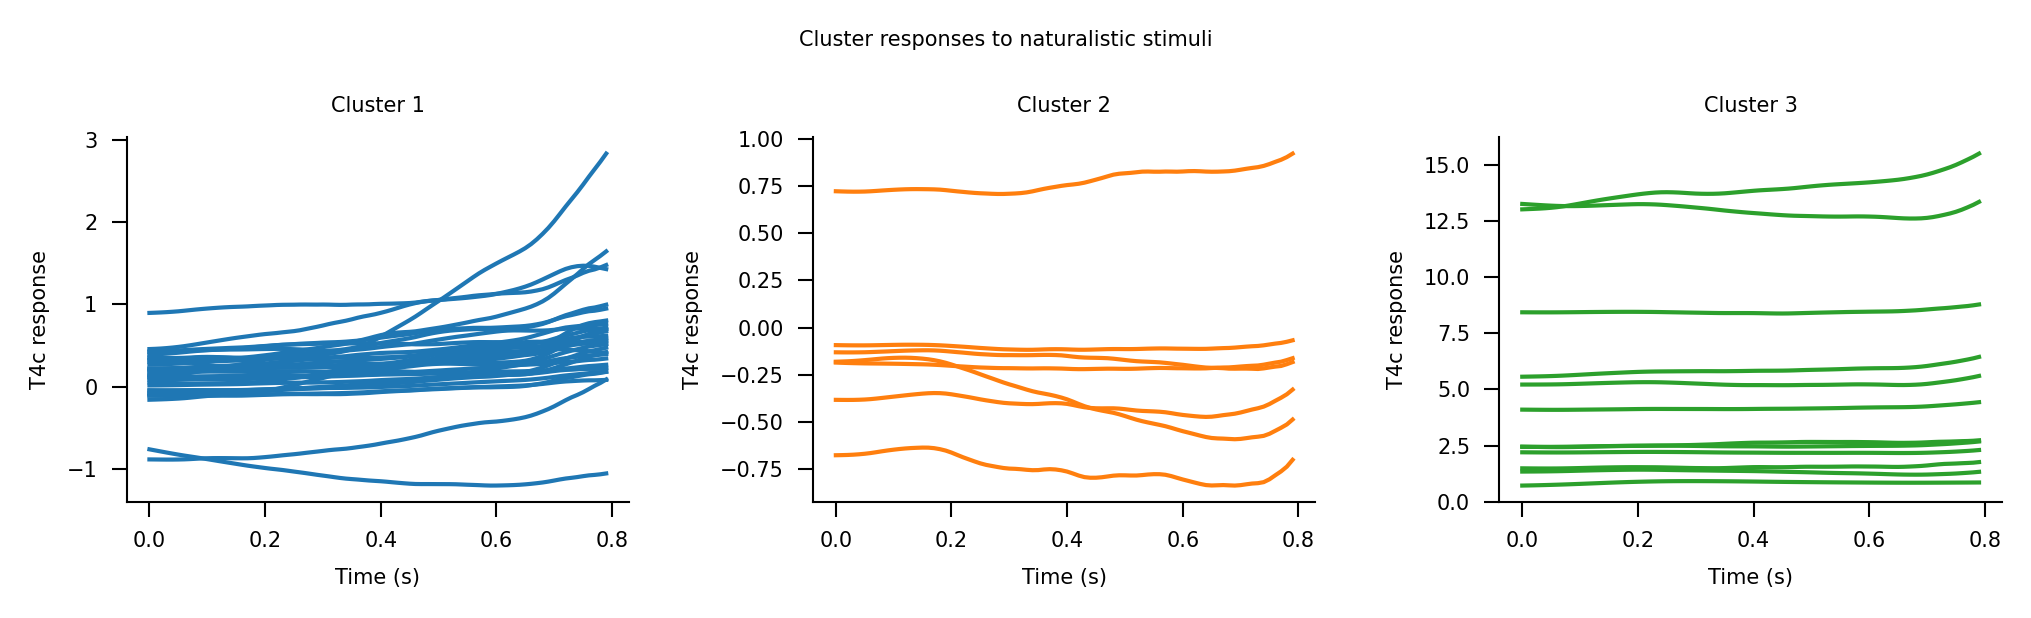

In [11]:
# Plot time series responses for each cluster
fig, axes = plt.subplots(1, len(cluster_to_indices), figsize=(7, 2))
colors = {i: color for i, color in enumerate(mcolors.TABLEAU_COLORS.values())}

# Newer version of xarray use duck-type numpy arrays which are currently not supported by flyvis. The workaround is to load the data into memory.
responses.load()

for cluster_id, indices in cluster_to_indices.items():
    ax = axes[cluster_id] if len(cluster_to_indices) > 1 else axes
    # Plot responses from this cluster to first stimulus sequence
    responses.sel(network_id=indices, sample=[0]).custom.where(
        cell_type=target_cell_type
    ).custom.plot_traces(
        x="time",
        plot_kwargs=dict(color=colors[cluster_id], add_legend=False, ax=ax),
    )
    
    ax.set_title(f"Cluster {cluster_id + 1}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{target_cell_type} response")

plt.tight_layout()
plt.suptitle("Cluster responses to naturalistic stimuli", y=1.02)
plt.show()

### 5.2 Moving edge responses reveal direction tuning differences

Let's test how our clusters differ in their responses to moving edges - a classic visual motion stimulus:


In [12]:
# Compute moving edge responses for the ensemble
print("Computing moving edge responses...")
stims_and_resps_moving_edge = ensemble.moving_edge_responses(speeds=[19], dt=1/100)

# Normalize responses for better comparison
stims_and_resps_moving_edge["responses"] /= np.abs(
    stims_and_resps_moving_edge["responses"]
).max(dim=("sample", "frame"))

print("Moving edge responses computed!")
print(f"Response shape: {stims_and_resps_moving_edge['responses'].shape}")


Computing moving edge responses...
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/53c7a9dc2da0b3d0944d80da996e4038/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/65b79ea79c701c4dd8efc1fca5510df6/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/ecf9391c7499dbe9bd90a9f46c1fbdc8/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/7df6d24b98ea492a4988b319dc79883b/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvi

/tmp/ipykernel_1710005/344201484.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


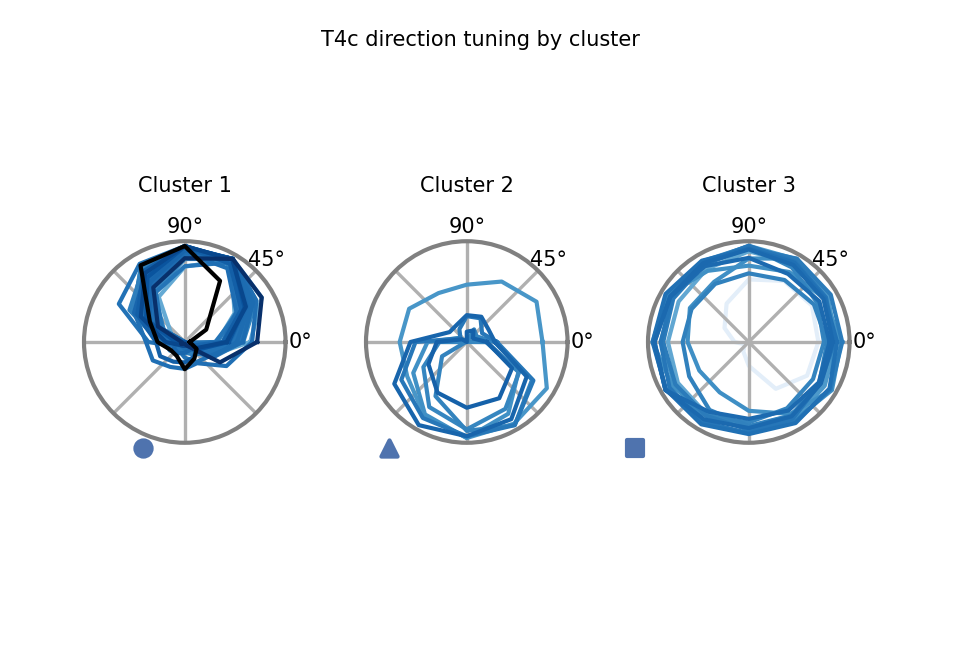

In [13]:
# Plot angular tuning curves for each cluster
fig, axes = plt.subplots(
    1, len(cluster_to_indices), 
    subplot_kw={"projection": "polar"}, 
    figsize=(len(cluster_to_indices), 2)
)

if len(cluster_to_indices) == 1:
    axes = [axes]

for cluster_id, indices in cluster_to_indices.items():
    ax = axes[cluster_id]
    
    # Plot angular tuning for this cluster
    plot_angular_tuning(
        stims_and_resps_moving_edge.sel(network_id=indices),
        cell_type=target_cell_type,
        intensity=1,  # bright edges
        colors=task_error.colors[indices],
        zorder=ensemble.zorder()[indices],
        groundtruth=True if cluster_id == 0 else False,
        fig=fig,
        ax=ax,
    )
    
    # Add cluster marker
    plt_utils.add_cluster_marker(
        fig, ax, marker=plt_utils.get_marker(cluster_id)
    )
    ax.set_title(f"Cluster {cluster_id + 1}")

plt.tight_layout()
plt.suptitle(f"{target_cell_type} direction tuning by cluster", y=1.02)
plt.show()


### 5.3 Temporal response patterns to moving edges

Let's examine the temporal dynamics of responses within each cluster:


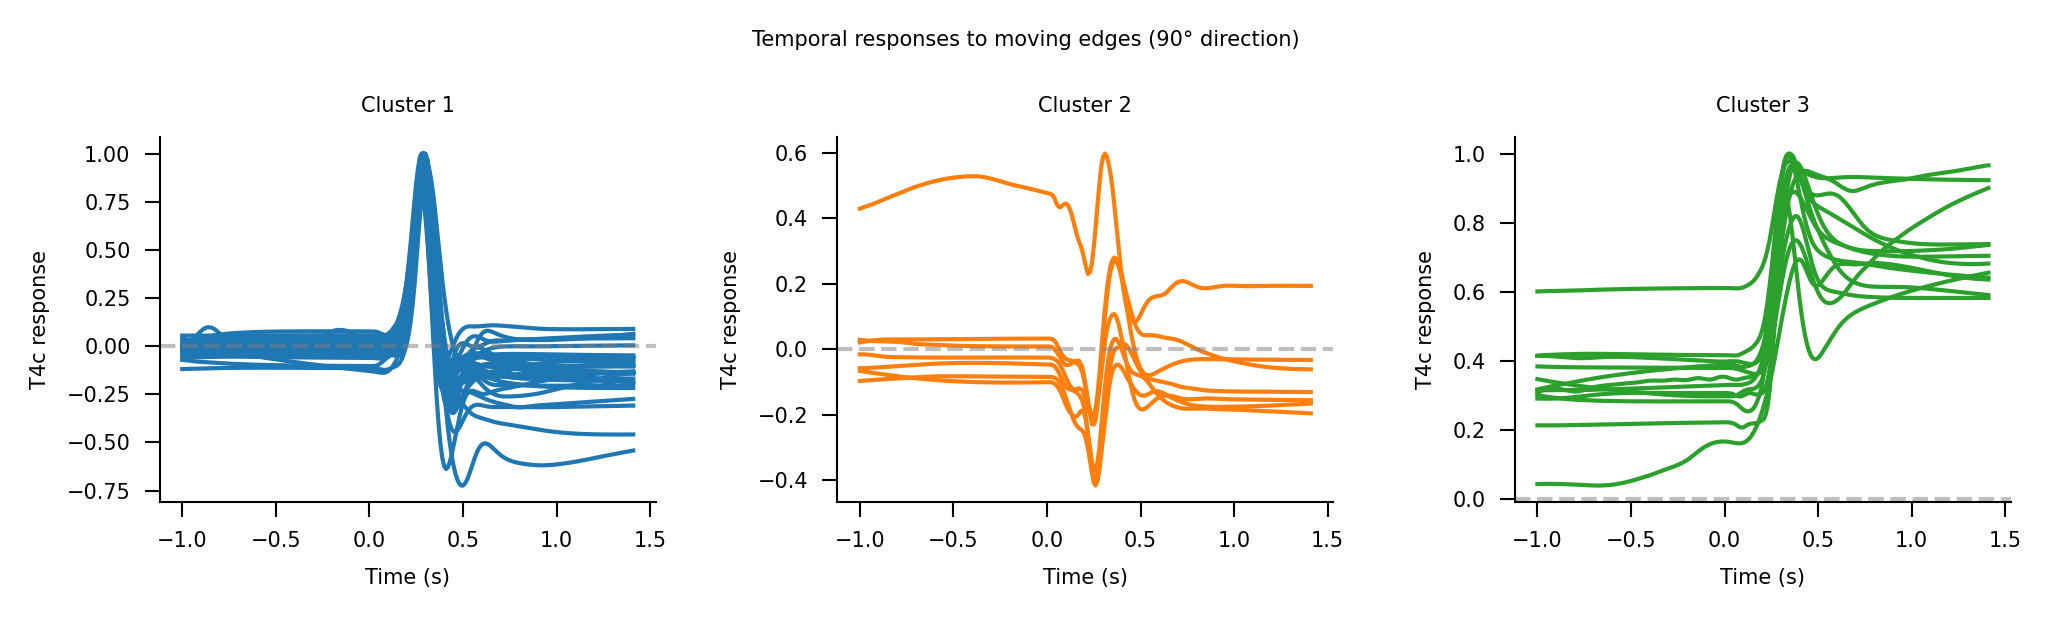

In [14]:
# Plot temporal responses to moving edges for each cluster
fig, axes = plt.subplots(1, len(cluster_to_indices), figsize=(7, 2))
if len(cluster_to_indices) == 1:
    axes = [axes]

for cluster_id, indices in cluster_to_indices.items():
    ax = axes[cluster_id]
    
    # Plot temporal response to motion in preferred direction (90 degrees)
    stims_and_resps_moving_edge['responses'].sel(network_id=indices).custom.where(
        cell_type=target_cell_type, intensity=1, speed=19, angle=90
    ).custom.plot_traces(
        x="time",
        plot_kwargs=dict(color=colors[cluster_id], add_legend=False, ax=ax),
    )
    
    ax.set_title(f"Cluster {cluster_id + 1}")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel(f"{target_cell_type} response")
    ax.axhline(0, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.suptitle("Temporal responses to moving edges (90° direction)", y=1.02)
plt.show()


### 🤔 Discussion Questions

1. How does each cluster strategy differ with respect to T4c function?
2. What are the characteristics of the temporal and peak responses?
3. How to verify whether these are viable hypotheses?

### 5.4 Flash responses reveal viable hypotheses

Finally, let's look at how clusters respond to simple light flashes to understand whether they are consistent with known data for other cell types:



=== Cluster 1 Flash Responses ===
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/000/__cache__/flyvis/analysis/stimulus_responses/compute_responses/000b20ebe7d3638677172c2494c5fb8d/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/001/__cache__/flyvis/analysis/stimulus_responses/compute_responses/00853be44d0475e8f78dc49b96207ddd/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/002/__cache__/flyvis/analysis/stimulus_responses/compute_responses/3c7f414b165adac4866dad7ce9e0852f/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/003/__cache__/flyvis/analysis/stimulus_responses/compute_responses/273c4faabda051262c4a1f5fea3175e4/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvi

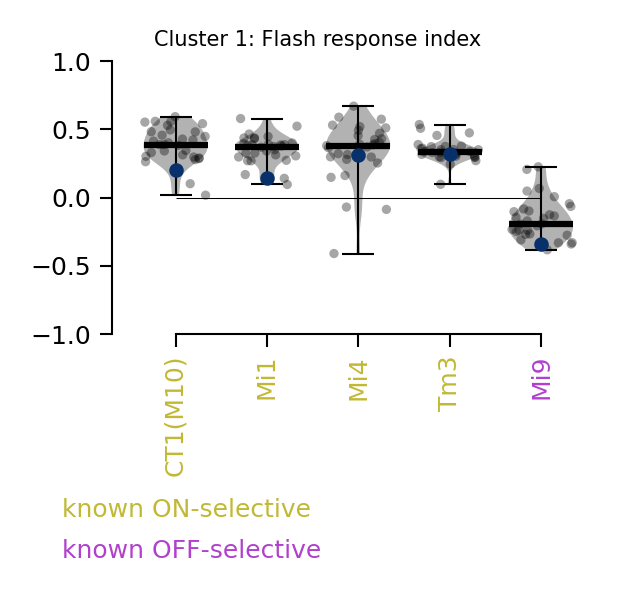


=== Cluster 2 Flash Responses ===
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/004/__cache__/flyvis/analysis/stimulus_responses/compute_responses/d162dc6c7d877aa0703c055e828db8c1/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/005/__cache__/flyvis/analysis/stimulus_responses/compute_responses/5120da673a3cbac50cb748dc5dabb87b/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/026/__cache__/flyvis/analysis/stimulus_responses/compute_responses/b349608f5cf7b70732221ca940052867/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/033/__cache__/flyvis/analysis/stimulus_responses/compute_responses/7f7c23a7fd67bf1df9a2bd9a62ca95c8/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvi

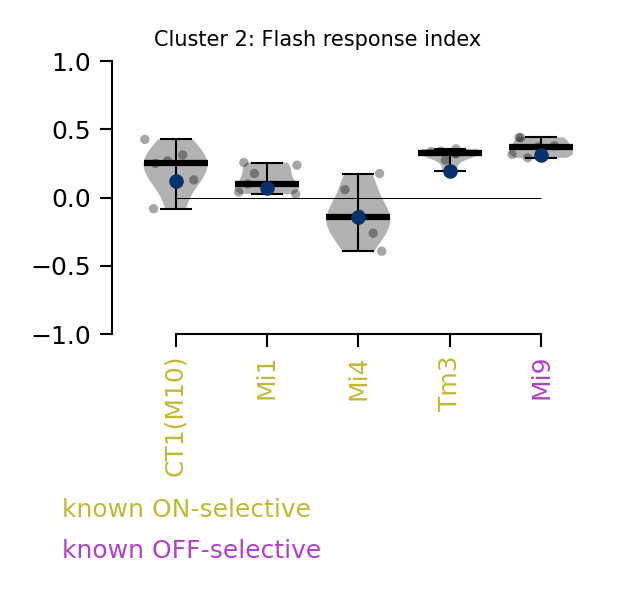


=== Cluster 3 Flash Responses ===
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/008/__cache__/flyvis/analysis/stimulus_responses/compute_responses/77a59c77e27e52d43c6e59a4bc694de7/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/010/__cache__/flyvis/analysis/stimulus_responses/compute_responses/fdaf3cc955abb85b2e041b54a82a1c3c/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/015/__cache__/flyvis/analysis/stimulus_responses/compute_responses/265f5f2a1cdb9e3d7acb4c37ed6ad326/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvis/data/results/flow/0000/025/__cache__/flyvis/analysis/stimulus_responses/compute_responses/c9c5cbd179ec6e8842757370e2490f73/output.h5
/home/lappalainenj@hhmi.org/flysim_tutorials/.venv/lib/python3.13/site-packages/flyvi

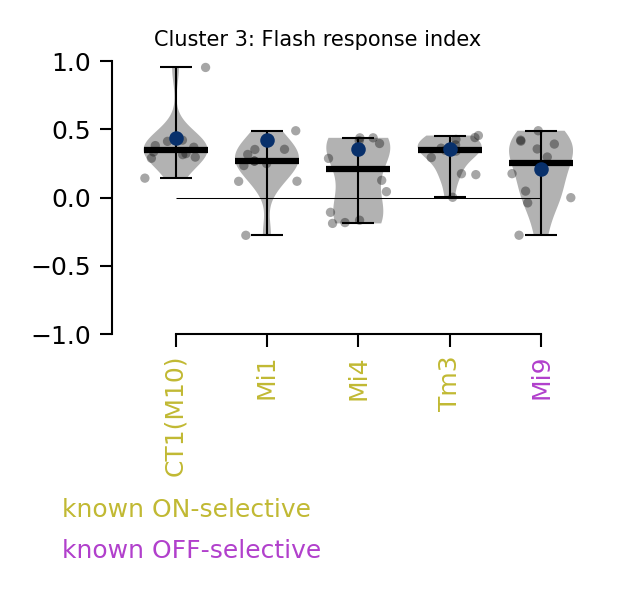

In [15]:
# Get flash responses for different clusters
flash_cell_types = ["Mi1", "Tm3", "Mi4", "Mi9", "CT1(M10)"]

for cluster_id, indices in cluster_to_indices.items():
    print(f"\n=== Cluster {cluster_id + 1} Flash Responses ===")
    
    with ensemble.select_items(indices):
        fig, ax = ensemble.flash_response_index(
            cell_types=flash_cell_types, 
            figsize=[2, 1.5]
        )
        plt.annotate("known ON-selective", xy=(-0.1, -0.6), xycoords='axes fraction',
                        ha='left', va='top', fontsize=6, color=ON_FR)
        plt.annotate("known OFF-selective", xy=(-0.1, -0.75), xycoords='axes fraction',
                        ha='left', va='top', fontsize=6, color=OFF_FR)
        plt.suptitle(f"Cluster {cluster_id + 1}: Flash response index", y=1.02)
        plt.show()


### 🤔 Discussion Questions

1. How do we refine our hypothesis for T4c function?

## Summary

In this tutorial, you've learned to:

1. **Work with ensemble models** to study computational diversity
2. **Apply UMAP** for dimensionality reduction of high-dimensional neural responses  
3. **Use Gaussian mixture models** to discover clusters of similar computational strategies
4. **Validate clusters** using simple, interpretable stimuli
5. **Interpret biological meaning** of computational differences

### Key insights

- **Computational diversity**: Neural networks trained on the same task can develop different computational strategies
- **Dimensionality reduction**: UMAP reveals structure in high-dimensional neural response data
- **Clustering validation**: Simple stimuli help interpret what clusters represent biologically
- **Mechanistic understanding**: Different clusters correspond to different ways of solving the same computational problem


## Project guiding ideas

### Idea 3: Across cell-type mechanistic interpretation with dimensionality reduction and clustering

**Goal**: Explore how predicted responses vary across the ensemble across cell-types using methods for dimensionality reduction and clustering.

**Background on ensembles**:  
flyvis provides access to a trained ensemble of neural network models. 
An ensemble contains several independently trained models that can exhibit different behaviors despite being trained on the same task. 

This variability arise from:
- Different random weight initializations
- Stochastic training 
- Different local minima in the optimization landscape

**Guiding questions**:
- If a model predicts upwards tuning for T4c does it also predict downwards tuning for T4d?
- How do predicted responses covary across all cell types?
- Do covariance patterns hold across the ensemble?
- Which sets of cell types could have the same function according to the ensemble?


```python
# Example: Load multiple models from an ensemble
model_1 = NetworkView("flow/0000/000")  # First model
model_2 = NetworkView("flow/0000/001")  # Second model  
# or equivalent
ensemble = EnsembleView("flow/0000)
model_1 = ensemble[0]
model_2 = ensemble[1]
```

### Idea 4: Deep mechanistic auxiliary targets

**Goal**: Develop auxiliary training targets to train properties such as mean, variance and coarse dynamic behavior of the cell type activity without task-training.

**Background**:  
Task-training alone does not guarantee that each model cell responds to a broad set of naturalistic stimuli, whereas biological neurons likely would.  
Moreover, responses across cell types in the model can in principle reach arbitrary scales and misalign in their steady-state values, which is biologically implausible.

**Guiding questions**:
- What are responses across cell types to grey screen like?
- What are responses across cell types to other simple stimuli like?
- What could be auxiliary targets for the cell type responses in the network to control such behavior?
- How to conceptualize an auxiliary target based on, for instance, information rate transfer (see refs below)?

## Supporting references

**General:**

Flyvis Documentation. https://turagalab.github.io/flyvis/.  
Lappalainen, J. K. et al. Connectome-constrained networks predict neural activity across the fly visual system. Nature 634, 1132–1140 (2024).

**Project Idea 4:**

Juusola, M. & de Polavieja, G. G. The rate of information transfer of naturalistic stimulation by graded potentials. J. Gen. Physiol. 122, 191–206 (2003).  
de Ruyter van Steveninck, R. R. & Laughlin, S. B. The rate of information transfer at graded-potential synapses. Nature 379, 642–645 (1996).